In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


### Number of Cores 

In [2]:
# number of cores
cores = [1, 2, 4, 8, 16]

### Training 

In [3]:
import copy
import time
from tqdm import tqdm

from func import exactConeAlignedCosine

def pipeline(reg, optmodel, dataloader):
    elapsed_grb, elapsed_clb, elapsed_nnls = [], [], []
    for processes in cores:
        # set random seed
        np.random.seed(42)
        torch.manual_seed(42)
        # gurobi
        time.sleep(1)
        print("Gurobi:")
        elapsed = trainingProcess(reg, optmodel, "gurobi", processes, dataloader)
        elapsed_grb.append(elapsed)
        # clarabel
        time.sleep(1)
        print("Clarabel:")
        elapsed = trainingProcess(reg, optmodel, "clarabel", processes, dataloader)
        elapsed_clb.append(elapsed)
        # nnls
        time.sleep(1)
        print("NNLS:")
        elapsed = trainingProcess(reg, optmodel, "nnls", processes, dataloader)
        elapsed_nnls.append(elapsed)
    return elapsed_grb, elapsed_clb, elapsed_nnls


def trainingProcess(reg, optmodel, solver, processes, dataloader):
    # copy predictor
    reg = copy.deepcopy(reg)
    # init loss
    ca_cos = exactConeAlignedCosine(optmodel, solver=solver, processes=processes)
    # train
    elapsed = train(reg, ca_cos, dataloader)
    #if processes > 1:
    #    ca_cos.pool.close()
    #    ca_cos.pool.join()
    return elapsed

        
def train(reg, loss_func, dataloader):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)
    # training
    tbar = tqdm(dataloader)
    tick = time.time()
    for data in tbar:
        # forward pass
        x, _, _, t_ctr = data
        # predict
        cp = reg(x)
        # loss
        loss = loss_func(cp, t_ctr)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tbar.set_description("Loss: {:8.4f}".format(loss.item()))
    # record time
    tock = time.time()
    elapsed = tock - tick
    return elapsed

### Plot

In [4]:
from matplotlib import pyplot as plt
import tol_colors as tc

def plot(cores, elapsed_grb, elapsed_clb, elapsed_nnls, title):
    # color map
    cset =  tc.tol_cset('light')
    fig = plt.figure(figsize=(16,8))
    plt.plot(cores, elapsed_grb, marker="o", linestyle="--", markersize=10, lw=5, color=cset.orange, label="Gurobi")
    plt.plot(cores, elapsed_clb, marker="o", linestyle="--", markersize=10, lw=5, color=cset.light_blue, label="Clarabel")
    plt.plot(cores, elapsed_nnls, marker="o", linestyle="--", markersize=10, lw=5, color=cset.mint, label="NNLS")
    plt.xlabel("Num of Cores", fontsize=36)
    plt.ylabel("Runtime per Epoch (Sec)", fontsize=36)
    plt.xticks(ticks=cores, fontsize=28)
    plt.yticks(fontsize=28)
    plt.legend(fontsize=32)
    plt.title(title, fontsize=36)
    plt.show()

### Shortest Path

In [5]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data, num_feat, grid, deg, e, seed=42)

In [6]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 4.3363291797418615
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [7]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, feats, costs=costs)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.47it/s]


In [8]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [9]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [10]:
elapsed_grb, elapsed_clb, elapsed_nnls = pipeline(reg, optmodel, loader_train)

Gurobi:
Num of cores: 1


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.08it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.00it/s]


NNLS:
Num of cores: 1


Loss:  -0.9986: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 73.85it/s]


Gurobi:
Num of cores: 2


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.79it/s]


Clarabel:
Num of cores: 2


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.27it/s]


NNLS:
Num of cores: 2


Loss:  -0.9986: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 55.19it/s]


Gurobi:
Num of cores: 4


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.49it/s]


Clarabel:
Num of cores: 4


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.74it/s]


NNLS:
Num of cores: 4


Loss:  -0.9986: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.74it/s]


Gurobi:
Num of cores: 8


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


Clarabel:
Num of cores: 8


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 20.91it/s]


NNLS:
Num of cores: 8


Loss:  -0.9986: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.20it/s]


Gurobi:
Num of cores: 16


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:19<00:00,  1.68it/s]


Clarabel:
Num of cores: 16


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 19.00it/s]


NNLS:
Num of cores: 16


Loss:  -0.9986: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.94it/s]


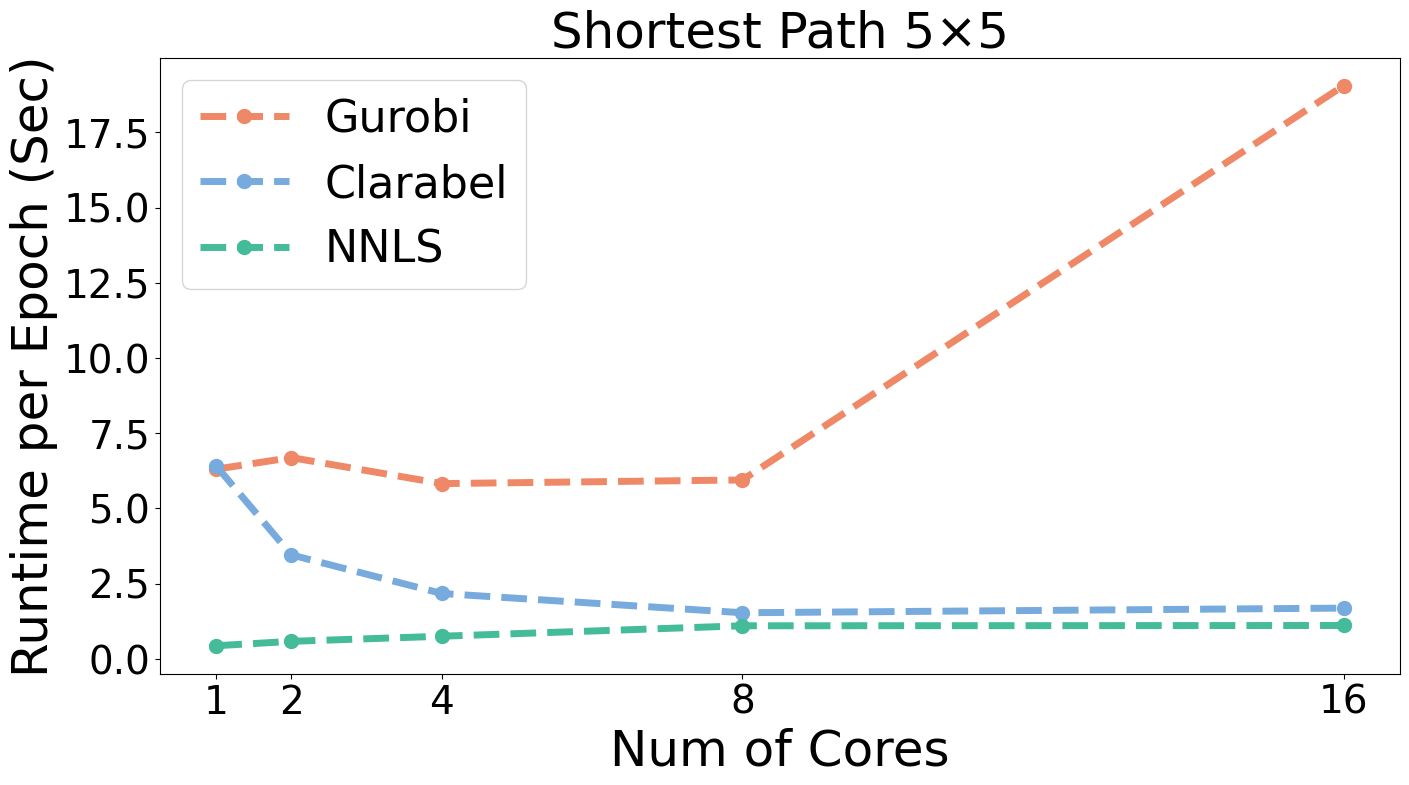

In [11]:
plot(cores, elapsed_grb, elapsed_clb, elapsed_nnls, "Shortest Path 5×5")

### TSP20

In [12]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data, num_feat, num_node, deg, e, seed=42)

In [13]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Obj: 60.6817
0 -> 10 -> 15 -> 14 -> 6 -> 13 -> 18 -> 7 -> 9 -> 16 -> 2 -> 11 -> 19 -> 1 -> 4 -> 12 -> 8 -> 5 -> 3 -> 17 -> 0


In [14]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, feats, costs=costs)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.85it/s]


In [15]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [16]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [17]:
elapsed_grb, elapsed_clb, elapsed_nnls = pipeline(reg, optmodel, loader_train)

Gurobi:
Num of cores: 1


Loss:  -0.9963: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:18<00:00,  1.72it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9976: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


NNLS:
Num of cores: 1


Loss:  -0.9965: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.37it/s]


Gurobi:
Num of cores: 2


Loss:  -0.9963: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.21it/s]


Clarabel:
Num of cores: 2


Loss:  -0.9976: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.53it/s]


NNLS:
Num of cores: 2


Loss:  -0.9965: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.94it/s]


Gurobi:
Num of cores: 4


Loss:  -0.9963: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.90it/s]


Clarabel:
Num of cores: 4


Loss:  -0.9976: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.43it/s]


NNLS:
Num of cores: 4


Loss:  -0.9965: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.59it/s]


Gurobi:
Num of cores: 8


Loss:  -0.9963: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.40it/s]


Clarabel:
Num of cores: 8


Loss:  -0.9976: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.17it/s]


NNLS:
Num of cores: 8


Loss:  -0.9965: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.77it/s]


Gurobi:
Num of cores: 16


Loss:  -0.9963: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.09it/s]


Clarabel:
Num of cores: 16


Loss:  -0.9976: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.03it/s]


NNLS:
Num of cores: 16


Loss:  -0.9965: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.21it/s]


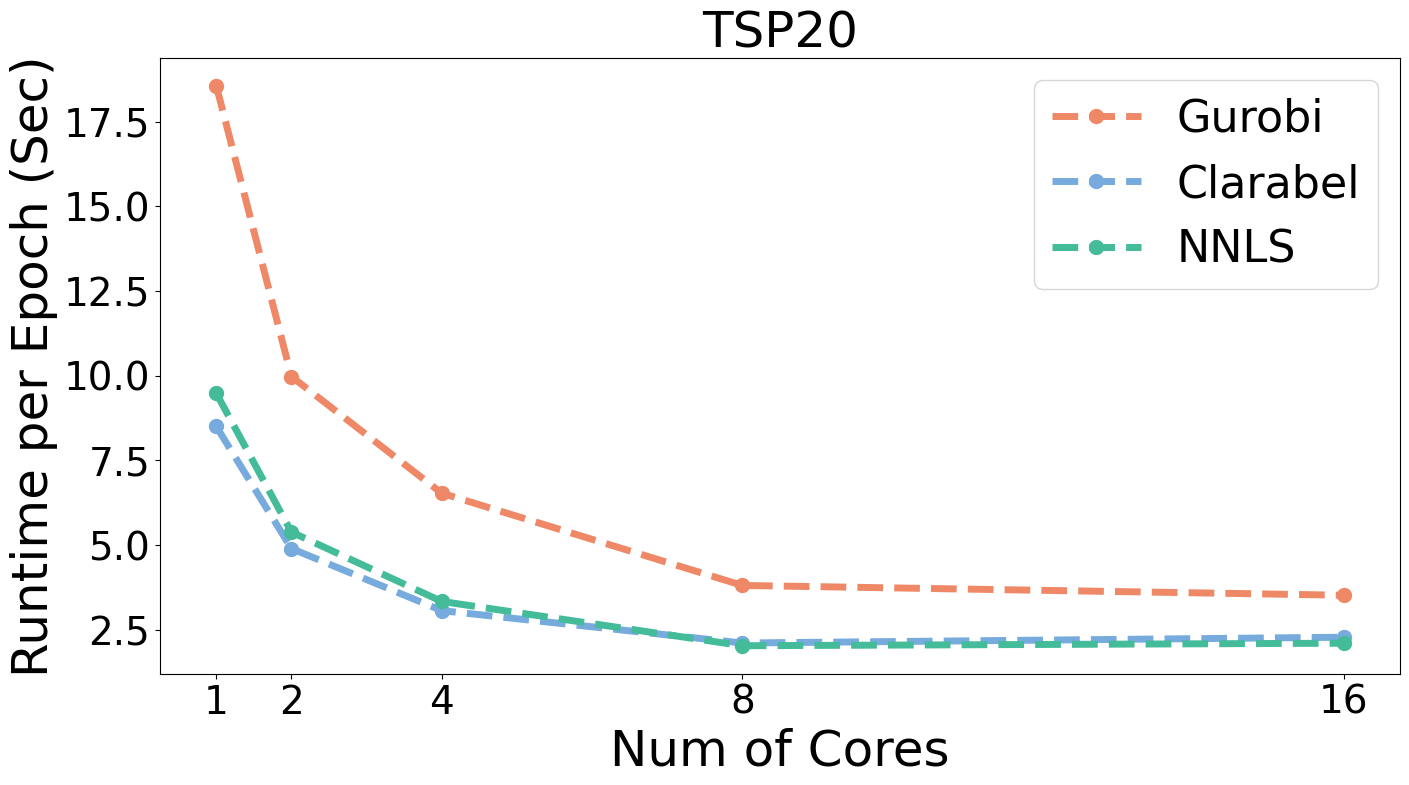

In [18]:
plot(cores, elapsed_grb, elapsed_clb, elapsed_nnls, "TSP20")

### TSP50

In [19]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data, num_feat, num_node, deg, e, seed=42)

In [20]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Obj: 83.2908
0 -> 5 -> 3 -> 41 -> 12 -> 20 -> 23 -> 49 -> 8 -> 22 -> 9 -> 24 -> 44 -> 14 -> 6 -> 19 -> 46 -> 39 -> 17 -> 37 -> 4 -> 32 -> 34 -> 45 -> 43 -> 26 -> 35 -> 33 -> 28 -> 38 -> 1 -> 40 -> 48 -> 29 -> 15 -> 10 -> 25 -> 30 -> 47 -> 11 -> 27 -> 2 -> 36 -> 18 -> 7 -> 13 -> 31 -> 42 -> 21 -> 16 -> 0


In [21]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, feats, costs=costs)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.68it/s]


In [22]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [23]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [24]:
elapsed_grb, elapsed_clb, elapsed_nnls = pipeline(reg, optmodel, loader_train)

Gurobi:
Num of cores: 1


Loss:  -0.9987: 100%|██████████████████████████████████████████████████████████████████| 32/32 [03:04<00:00,  5.76s/it]


Clarabel:
Num of cores: 1


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [01:07<00:00,  2.11s/it]


NNLS:
Num of cores: 1


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [30:35<00:00, 57.37s/it]


Gurobi:
Num of cores: 2


Loss:  -0.9987: 100%|██████████████████████████████████████████████████████████████████| 32/32 [02:01<00:00,  3.81s/it]


Clarabel:
Num of cores: 2


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:44<00:00,  1.38s/it]


NNLS:
Num of cores: 2


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [15:34<00:00, 29.22s/it]


Gurobi:
Num of cores: 4


Loss:  -0.9987: 100%|██████████████████████████████████████████████████████████████████| 32/32 [01:53<00:00,  3.55s/it]


Clarabel:
Num of cores: 4


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:37<00:00,  1.17s/it]


NNLS:
Num of cores: 4


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [10:36<00:00, 19.89s/it]


Gurobi:
Num of cores: 8


Loss:  -0.9987: 100%|██████████████████████████████████████████████████████████████████| 32/32 [02:14<00:00,  4.21s/it]


Clarabel:
Num of cores: 8


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:34<00:00,  1.07s/it]


NNLS:
Num of cores: 8


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [13:32<00:00, 25.38s/it]


Gurobi:
Num of cores: 16


Loss:  -0.9987: 100%|██████████████████████████████████████████████████████████████████| 32/32 [02:44<00:00,  5.13s/it]


Clarabel:
Num of cores: 16


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.11s/it]


NNLS:
Num of cores: 16


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [19:16<00:00, 36.14s/it]


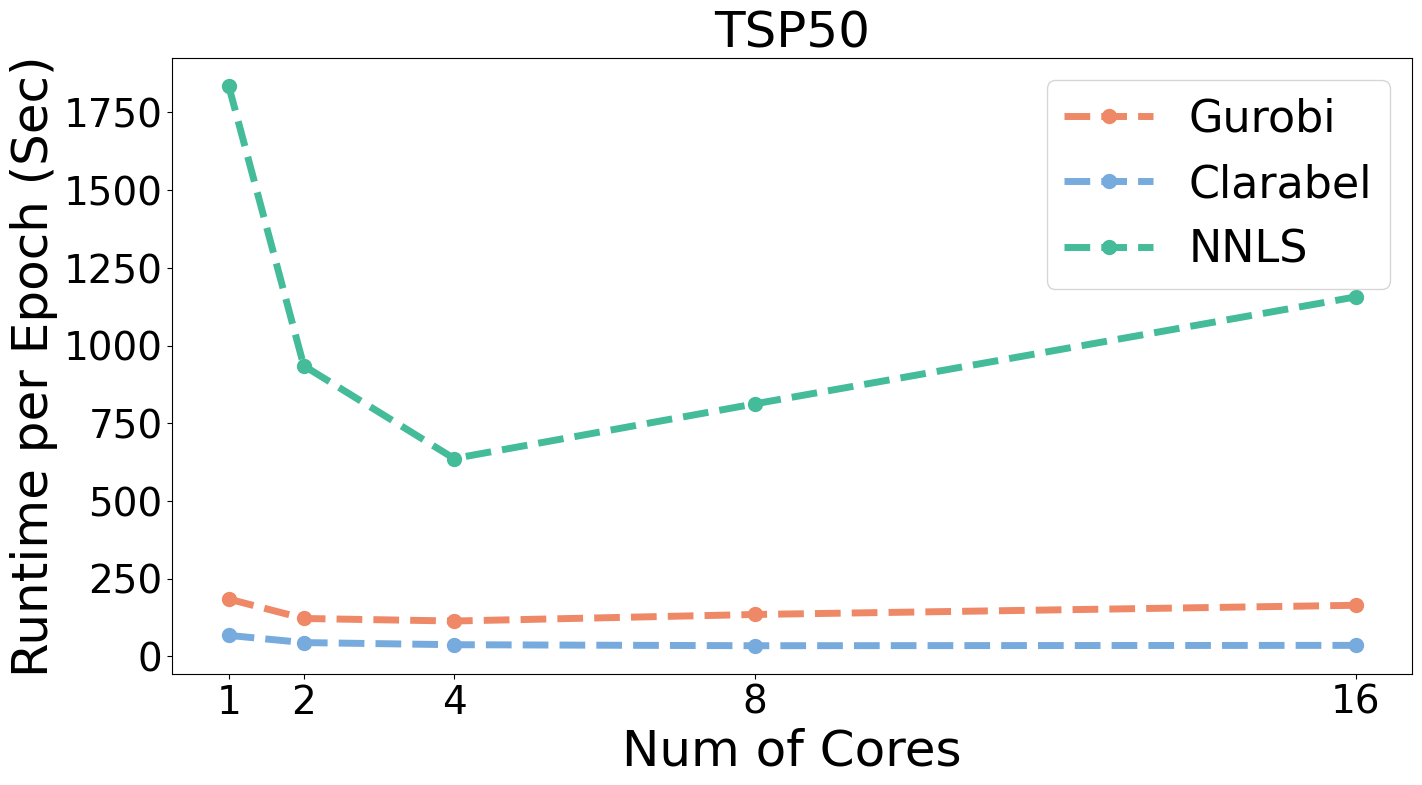

In [25]:
plot(cores, elapsed_grb, elapsed_clb, elapsed_nnls, "TSP50")